![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx, and `meta-llama/Meta-Llama-3-8B` to Fine Tune with online banking queries annotated

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.
- Full Fine Tuning are supported since CPD 5.0.3 release.


## Notebook content

This notebook contains the steps and code to demonstrate support of fine tuning in watsonx.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goal

The goal of this notebook is to demonstrate how to:
- upload of dataset with prompts
- trigger fine tuning process
- review of fine tuning process details
- deploy fine-tuned model
- inference of fine-tuned model
- compare with base model


## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Data loading](#data_loading)
- [Initialize experiment](#initialize)
- [Run Fine Tuning](#run_tuning)
- [Fine Tuning details](#run_details)
- [List historical Fine Tuning experiments](#historical_runs)
- [Deploy Tuned Model](#deploy)
- [Preparing data for testing process](#test_data)
- [Foundation Models Inference on `watsonx.ai`](#models_inference)
- [Deploy Base Model](#deploy_base)
- [Comparison of prediction results](#comparison)
- [Clean up](#cleanup)
- [Summary and next steps](#summary)


<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `datasets` and dependecies

In [ ]:
!pip install wget | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install "scikit-learn==1.3" | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [ ]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.0"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.0"
)

```

### Defining the project id
The Foundation Model requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project id.

In [ ]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

Create an instance of APIClient with authentication details.

To be able to interact with all resources available in Watson Machine Learning, you need to set **project_id** which you will be using.

In [2]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials, project_id)

<a id="data_loading"></a>
## Preparing data for Fine Tuning training process

This example uses the <a href="https://huggingface.co/datasets/PolyAI/banking77" target="_blank" rel="noopener no referrer">Banking77</a> training dataset with 200 samples. 

In [3]:
import os
import wget
import json
import pandas as pd
from pathlib import Path

filename="train.csv"
base_url = "https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/"

path = Path(os.getcwd()) / filename
if path.exists():
    path.unlink()
wget.download(f"{base_url}{filename}")

banking_df = pd.read_csv("train.csv").sample(n=200, random_state=42)

data = [
    {"input": row["text"], "output": row["category"]}
    for _, row in banking_df.iterrows()
]

ft_training_data = "ft_training_data.json"
with open(ft_training_data, "w", encoding="utf-8") as json_file:
    json.dump(data, json_file, indent=4, ensure_ascii=False)

To create a data asset for your project, execute the cell below. The asset will be utilized in the Fine-Tuning training process.

In [4]:
asset_details = client.data_assets.create(name=ft_training_data, file_path=ft_training_data)
asset_id = client.data_assets.get_id(asset_details)

Creating data asset...
SUCCESS


Define connection information to training data.

In [5]:
from ibm_watsonx_ai.helpers import DataConnection
from ibm_watsonx_ai.helpers.connections.base_connection import BaseConnection

data_conn = DataConnection(data_asset_id=asset_id, connection=BaseConnection())

<a id="initialize"></a>
## Initialize Fine Tuning experiment 

In [6]:
from ibm_watsonx_ai.experiment import TuneExperiment

experiment = TuneExperiment(credentials, project_id=project_id)

To display all available custom models that can be utilized in the Fine-Tuning process, execute the cell below.

In [47]:
[model["model_id"] for model in client.foundation_models.get_custom_model_specs().get("resources")]

['ibm-granite/granite-3.0-8b-base',
 'meta-llama/Meta-Llama-3-8B',
 'mistralai/Mistral-7B-v0.3']

Define `fine_tuner` parameters.

In [7]:
fine_tuner = experiment.fine_tuner(
     name='IBM watsonx.ai SDK - Fine Tune with online banking queries annotated',
     description='IBM watsonx.ai SDK - Fine Tune with online banking queries annotated',
     base_model='meta-llama/Meta-Llama-3-8B',
     task_id="classification",
     num_epochs=5,
     learning_rate=1e-05,
     batch_size=4,
     accumulate_steps=2,
     verbalizer="### Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rate, card swallowed, cash withdrawal charge, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card payment, declined cash withdrawal, declined transfer, direct debit payment not recognised, disposable card limits, edit personal details, exchange charge, exchange rate, exchange via app, extra charge on statement, failed transfer, fiat currency support, get disposable virtual card, get physical card, getting spare card, getting virtual card, lost or stolen card, lost or stolen phone, order physical card, passcode forgotten, pending card payment, pending cash withdrawal, pending top up, pending transfer, pin blocked, receiving money, Refund not showing up, request refund, reverted card payment?, supported cards and currencies, terminate account, top up by bank transfer charge, top up by card charge, top up by cash or cheque, top up failed, top up limits, top up reverted, topping up by card, transaction charged twice, transfer fee charged, transfer into account, transfer not received by recipient, transfer timing, unable to verify identity, verify my identity, verify source of funds, verify top up, virtual card not working, visa or mastercard, why verify identity, wrong amount of cash received, wrong exchange rate for cash withdrawal\n\n### Input:\n{{input}}\n\n### Response:\n{{output}}",
     response_template="\n### Response:\n",
     auto_update_model=True,
     gpu={"num": 1},
)

You can review previous set parameters with `get_params()` method.

In [8]:
fine_tuner.get_params()

{'base_model': {'model_id': 'meta-llama/Meta-Llama-3-8B'},
 'task_id': 'classification',
 'num_epochs': 5,
 'learning_rate': 1e-05,
 'batch_size': 4,
 'accumulate_steps': 2,
 'verbalizer': '### Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rate, card swallowed, cash withdrawal charge, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card payment, declined cash withdrawal, declined transfer, direct debit payment not recognised, disposable card limits, edit personal details, exchange charge, exchang

<a id="run_tuning"></a>
## Run Fine Tuning


Run a fine tuning process of foundation model on top of the training data referenced by DataConnection (tuning may take some time).


By changing the `background_mode` parameter to `True`, the fine tuning process will run in the background.

In [14]:
tuning_details = fine_tuner.run(training_data_references=[data_conn], background_mode=False)



##############################################

Running '87ad2a2a-92e6-47fa-9b13-0f5dae76e4f1'

##############################################


pending........
running...........................
completed
Training of '87ad2a2a-92e6-47fa-9b13-0f5dae76e4f1' finished successfully.


<a id="run_details"></a>
## Fine Tuning details


Check status/state of initialized Fine Tuning run if ran in background mode or when process finish if background mode is off.

In [15]:
fine_tuner.get_run_status()

'completed'

Get fine tuning run details.

In [16]:
fine_tuner.get_run_details()

{'entity': {'auto_update_model': True,
  'parameters': {'accumulate_steps': 2,
   'base_model': {'model_id': 'meta-llama/Meta-Llama-3-8B'},
   'batch_size': 4,
   'gpu': {'num': 1},
   'learning_rate': 1e-05,
   'max_seq_length': 1024,
   'num_epochs': 5,
   'response_template': '\n### Response:\n',
   'task_id': 'classification',
   'verbalizer': '### Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rate, card swallowed, cash withdrawal charge, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card p

Alternatively you can use `get_run_details()` method with metrics.

```python
fine_tuner.get_run_details(include_metrics=True)
```

Let's summarize the run.

In [17]:
fine_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_87ad2a2a-92e6-47fa-9b13-0f5dae76e4f1,[fine tuning],meta-llama/Meta-Llama-3-8B,True,5,0.0067


Plot the learning curves to visualize the loss function.

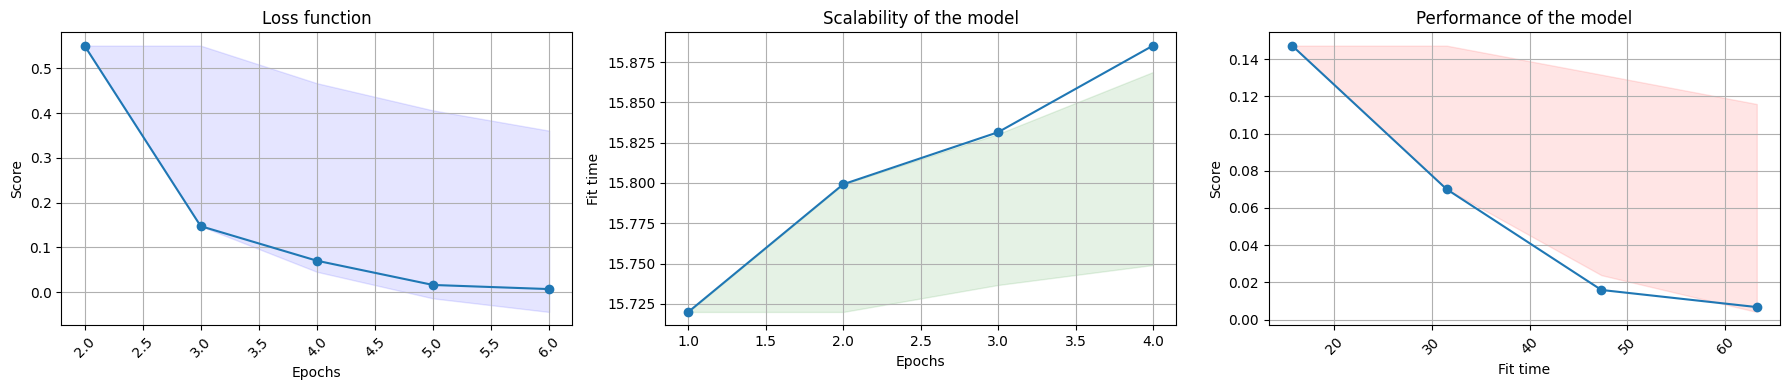

In [18]:
fine_tuner.plot_learning_curve()

<a id="historical_runs"></a>

## List historical Fine Tuning experiments

Return stored experiments in a table format.

In [83]:
experiment.runs.list()

,timestamp,run_id,state,tuning name
0,2024-09-27T10:48:38.000Z,d7ba6fc1-2245-4bb7-99a5-b474d710f41d,completed,Sample SDK fine tuner run auto_update True
1,2024-09-27T10:41:07.746Z,1a24032e-70fb-4318-85f8-6d157bd64d9c,completed,Sample SDK fine tuner run auto_update True
2,2024-09-27T10:28:01.718Z,37fda7da-f5e5-4002-9a07-ea9b316f90f7,completed,Sample SDK fine tuner run auto_update True
3,2024-09-27T10:12:02.767Z,e452fb6d-491d-4f46-8479-6b14de52a75c,completed,Sample SDK fine tuner run auto_update True


You can specify `historical_tuner` using `run_id`

In [ ]:
historical_tuner = experiment.runs.get_tuner("<Fine_Tuner_ID>")

Check status/state of historical_tuner and get historical_tuner details.

In [ ]:
historical_tuner.get_run_details()

<a id="deploy"></a>
## Deploy Tuned Model

You can specify `tuned_model_id` from tuning details.

In [19]:
tuned_model_id = None

if 'id' in tuning_details.get('entity', {}).get("tuned_model", {}):
    tuned_model_id = tuning_details['entity']['tuned_model']["id"]
tuned_model_id

'cae6b499-6d08-4a34-89be-b935f7ab335e'

In [20]:
hw_spec_id = client.hardware_specifications.get_id_by_name("WX-S")

Create online deployment for published model.

In [17]:
client.deployments.list()

,ID,NAME,STATE,CREATED,ARTIFACT_TYPE,SPEC_STATE,SPEC_REPLACEMENT
0,13989785-2adf-43e5-99ed-0fbbf2c2419c,BASE Model,ready,2025-01-22T13:49:42.471Z,custom_foundation_model,supported,
1,e101fc0f-b241-4cca-ac89-49f0b80051ed,FT DEPLOYMENT SDK - project,ready,2025-01-22T13:40:30.562Z,fine_tune,supported,


In [21]:
from datetime import datetime
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "FT DEPLOYMENT SDK - project",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"ft_sdk_deployment_{datetime.now().strftime('%Y_%m_%d_%H%M%S')}",
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {
        "id": hw_spec_id,
        "num_nodes": 1
    }
}

tuned_model_deployment_details = client.deployments.create(tuned_model_id, meta_props)



######################################################################################

Synchronous deployment creation for id: 'cae6b499-6d08-4a34-89be-b935f7ab335e' started

######################################################################################


initializing........................................
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='84ad2335-9a26-4cb2-b588-b896a0204b2d'
-----------------------------------------------------------------------------------------------




Additionally you can get deployment details by printing `tuned_model_deployment_details`

In [ ]:
tuned_model_deployment_details

You can specify `deployment_id` from deployment details.

In [22]:
tuned_model_deployment_id = tuned_model_deployment_details['metadata']['id']
tuned_model_deployment_id

'84ad2335-9a26-4cb2-b588-b896a0204b2d'

<a id="test_data"></a>
## Preparing data for testing process

This example uses the <a href="https://huggingface.co/datasets/PolyAI/banking77" target="_blank" rel="noopener no referrer">Banking77</a> testing dataset with 200 samples. 

In [23]:
filename="test.csv"

path = Path(os.getcwd()) / filename
if path.exists():
    path.unlink()
wget.download(f"{base_url}{filename}")

banking_test_df = pd.read_csv("train.csv").sample(n=200, random_state=42)

The instruction will be utilized in the prompt provided to the Base Model to guide it toward generating the correct response.

In [24]:
instruction = "Instruction:\nClassify the text into one of the following categories: activate my card, age limit, apple pay or google pay, atm support, automatic top up, balance not updated after bank transfer, balance not updated after cheque or cash deposit, beneficiary not allowed, cancel transfer, card about to expire, card acceptance, card arrival, card delivery estimate, card linking, card not working, card payment fee charged, card payment not recognised, card payment wrong exchange rate, card swallowed, cash withdrawal charge, cash withdrawal not recognised, change pin, compromised card, contactless not working, country support, declined card payment, declined cash withdrawal, declined transfer, direct debit payment not recognised, disposable card limits, edit personal details, exchange charge, exchange rate, exchange via app, extra charge on statement, failed transfer, fiat currency support, get disposable virtual card, get physical card, getting spare card, getting virtual card, lost or stolen card, lost or stolen phone, order physical card, passcode forgotten, pending card payment, pending cash withdrawal, pending top up, pending transfer, pin blocked, receiving money, Refund not showing up, request refund, reverted card payment?, supported cards and currencies, terminate account, top up by bank transfer charge, top up by card charge, top up by cash or cheque, top up failed, top up limits, top up reverted, topping up by card, transaction charged twice, transfer fee charged, transfer into account, transfer not received by recipient, transfer timing, unable to verify identity, verify my identity, verify source of funds, verify top up, virtual card not working, visa or mastercard, why verify identity, wrong amount of cash received, wrong exchange rate for cash withdrawal\n\n"

In [42]:
prompts_batch = list(banking_test_df.text)
prompts_batch_with_instruction = [instruction + prompt for prompt in prompts_batch]
predictions = list(banking_test_df.category)

<a id="models_inference"></a>
## Foundation Models Inference on `watsonx.ai`

Provide a set of model parameters.

In [26]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

generate_params = {
    GenParams.MAX_NEW_TOKENS: 256,
}

Initialize the `ModelInference` class with `tuned_model_deployment_id`.

In [27]:
from ibm_watsonx_ai.foundation_models import ModelInference

tuned_model = ModelInference(
    deployment_id=tuned_model_deployment_id,
    api_client=client,
    params=generate_params
)

Get deployment model inference details.

In [ ]:
tuned_model.get_details()

### Calculate the accuracy of tuned model

In [29]:
tuned_model_results = tuned_model.generate_text(prompt=prompts_batch)

In [30]:
from sklearn.metrics import accuracy_score

tuned_model_accuracy_score = accuracy_score(predictions, tuned_model_results)

print(f'accuracy_score: {tuned_model_accuracy_score}')

accuracy_score: 0.99


<a id="deploy_base"></a>
## Deploy Base Model

Create online deployment for base model.

In [31]:
sw_spec_id = client.software_specifications.get_id_by_name('watsonx-cfm-caikit-1.1')

metadata = {
    client.repository.ModelMetaNames.NAME: 'Base FT model',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_ID: sw_spec_id,
    client.repository.ModelMetaNames.TYPE: "custom_foundation_model_1.0"
}

In [32]:
stored_base_model_details = client.repository.store_model(model="meta-llama/Meta-Llama-3-8B", meta_props=metadata)

In [33]:
stored_base_model_asset_id = client.repository.get_model_id(stored_base_model_details)

In [34]:
from datetime import datetime
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "Base FT Model",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"ft_sdk_deployment_{datetime.now().strftime('%Y_%m_%d_%H%M%S')}",
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {
        "id": hw_spec_id,
        "num_nodes": 1
    }
}

base_model_deployment_details = client.deployments.create(stored_base_model_asset_id, meta_props)



######################################################################################

Synchronous deployment creation for id: 'e267f513-0aff-4ef1-b627-3e0111a5aa70' started

######################################################################################


initializing................................
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='eab867d9-5eec-446f-80ce-dee87d2dc2cc'
-----------------------------------------------------------------------------------------------




In [35]:
base_model_deployment_id = base_model_deployment_details['metadata']['id']
base_model_deployment_id

'eab867d9-5eec-446f-80ce-dee87d2dc2cc'

Initialize the `ModelInference` class with `base_model_deployment_id`.

In [36]:
base_model = ModelInference(
    deployment_id=base_model_deployment_id,
    params=generate_params,
    api_client=client
)

### Calculate the accuracy of base model

In [44]:
base_model_results = base_model.generate_text(prompt=prompts_batch_with_instruction)

In [47]:
from sklearn.metrics import accuracy_score

base_model_accuracy_score = accuracy_score(predictions, base_model_results)

print(f'accuracy_score: {base_model_accuracy_score}')

accuracy_score: 0.0


<a id="comparison"></a>
## Comparison of prediction results

In [48]:
from tabulate import tabulate

data = [
    ["Accuracy Score", base_model_accuracy_score, tuned_model_accuracy_score],
]

headers = ["Metric", "Base Model", "Tuned Model"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+----------------+--------------+---------------+
| Metric         |   Base Model |   Tuned Model |
+================+==============+===============+
| Accuracy Score |            0 |          0.99 |
+----------------+--------------+---------------+


<a id="cleanup"></a>
## Clean up

To delete the current fine tuning experiment, use the `cancel_run` method.

**Warning:** Be careful: once you delete an experiment, you will no longer be able to refer to it.

In [ ]:
fine_tuner.cancel_run(hard_delete=True)

To delete the deployment, use the `delete` method. 

**Warning:** Keeping the deployment active may lead to unnecessary consumption of Compute Unit Hours (CUHs).

In [ ]:
client.deployments.delete(base_model_deployment_id)

In [ ]:
client.deployments.delete(tuned_model_deployment_id)

<a id="summary"></a>
## Summary and next steps

You successfully completed this notebook!.

You learned how to use fine tuning in watsonx with online banking queries annotated.
 
Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors: 
 **Mateusz Szewczyk**, Software Engineer at IBM watsonx.ai.

Copyright © 2025 IBM. This notebook and its source code are released under the terms of the MIT License.